importing the dataset to notebook environment

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sunilthite/llm-detect-ai-generated-text-dataset")

print("Path to dataset files:", path)

C:\Users\Admin\Documents\TextClassifierModel\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Admin\.cache\kagglehub\datasets\sunilthite\llm-detect-ai-generated-text-dataset\versions\1


In [2]:
path

'C:\\Users\\Admin\\.cache\\kagglehub\\datasets\\sunilthite\\llm-detect-ai-generated-text-dataset\\versions\\1'

In [3]:
import pandas as pd
essay_df = pd.read_csv(filepath_or_buffer=path+"/Training_Essay_Data.csv")

In [4]:
print(f"Column Names: {essay_df.columns}")

Column Names: Index(['text', 'generated'], dtype='object')


In [5]:
print(f"shape of the Dataframe: {essay_df.shape}")

shape of the Dataframe: (29145, 2)


In [6]:
print(f"Datatypes and Non-null coounts: {essay_df.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29145 entries, 0 to 29144
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       29145 non-null  object
 1   generated  29145 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 455.5+ KB
Datatypes and Non-null coounts: None


In [7]:
print(f"number of duplicated records: {essay_df.duplicated().sum()}")

number of duplicated records: 1805


In [8]:
print(f"Statistical summary of the numerical columns \n {essay_df.describe()}")

Statistical summary of the numerical columns 
           generated
count  29145.000000
mean       0.399279
std        0.489759
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


In [9]:
print(essay_df.isna().sum())

text         0
generated    0
dtype: int64


In [10]:
categorical_cols = essay_df.select_dtypes(include='object')

In [11]:
print(f"value Counts for generated: {essay_df['generated'].value_counts()}")

value Counts for generated: generated
0    17508
1    11637
Name: count, dtype: int64


## visualizations
### visualizing class imbalaces using countplot

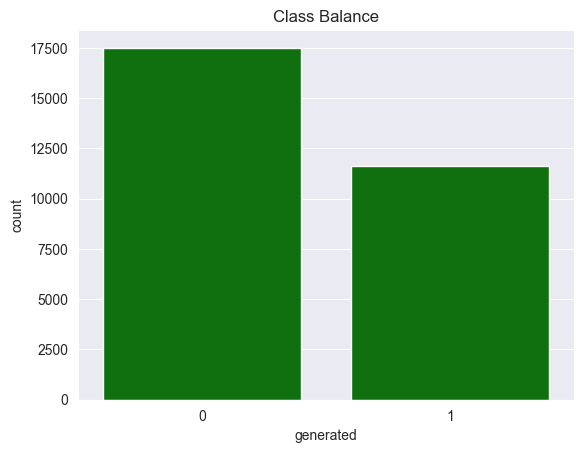

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='generated', data=essay_df, color='green')
plt.title('Class Balance')
plt.show()

### visualizing word coumts for the two classes

In [14]:
from wordcloud import WordCloud

human_text = ' '.join(essay_df[essay_df['generated'] == 0]['text'])
ai_text = ' '.join(essay_df[essay_df['generated'] == 1]['text'])

wordcloud_human = WordCloud(width=800, height=400, background_color='white').generate(human_text)
wordcloud_ai = WordCloud(width= 800, height=400, background_color='black').generate(ai_text)

#### displaying the human wordcloud

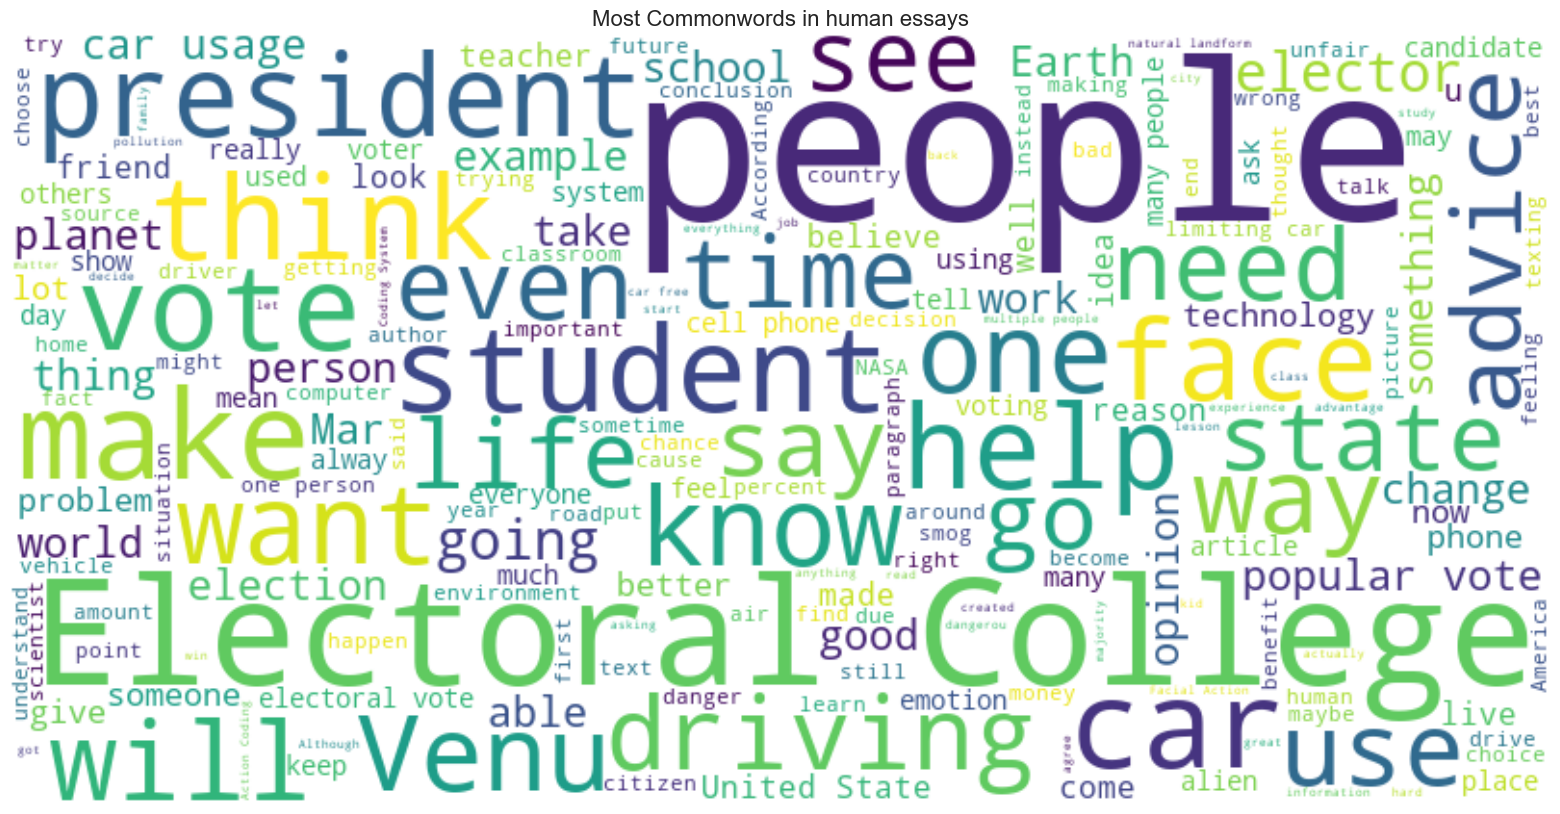

In [15]:
plt.figure(figsize=(20, 10))

plt.imshow(wordcloud_human, interpolation='bilinear')
plt.title('Most Commonwords in human essays', fontsize=16)
plt.axis('off')
plt.show()

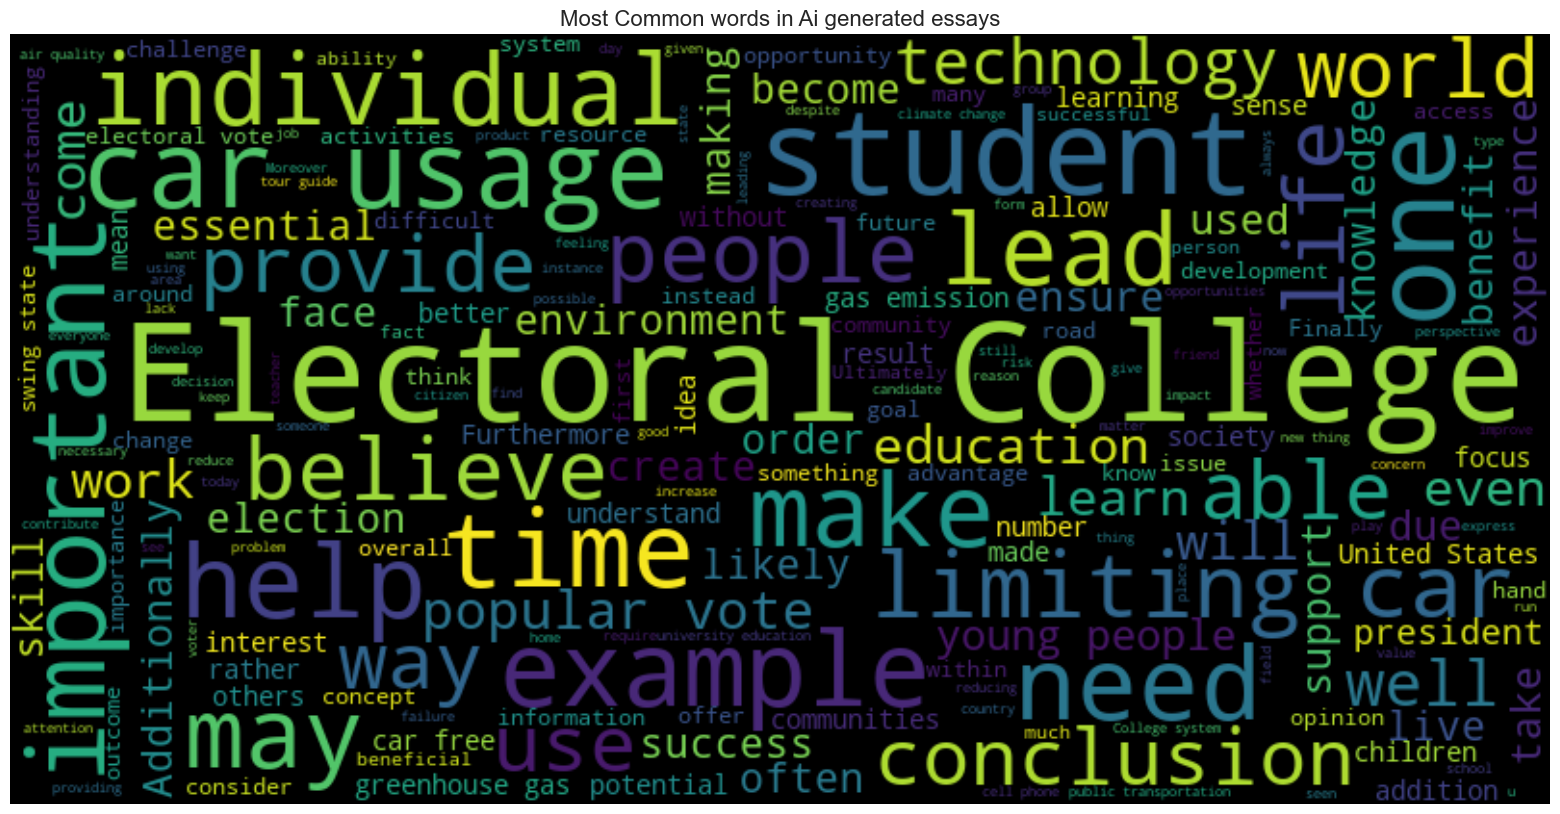

In [16]:
plt.figure(figsize=(20, 10))

plt.imshow(wordcloud_ai, interpolation='bilinear')
plt.title('Most Common words in Ai generated essays', fontsize=16)
plt.axis('off')
plt.show()

## 2. Displaying the distribution of essay lengths

the first part creates a new column word_count and then visualizes its distribution for both classes using a histogram

In [17]:
essay_df['word_count'] = essay_df['text'].str.split().str.len()

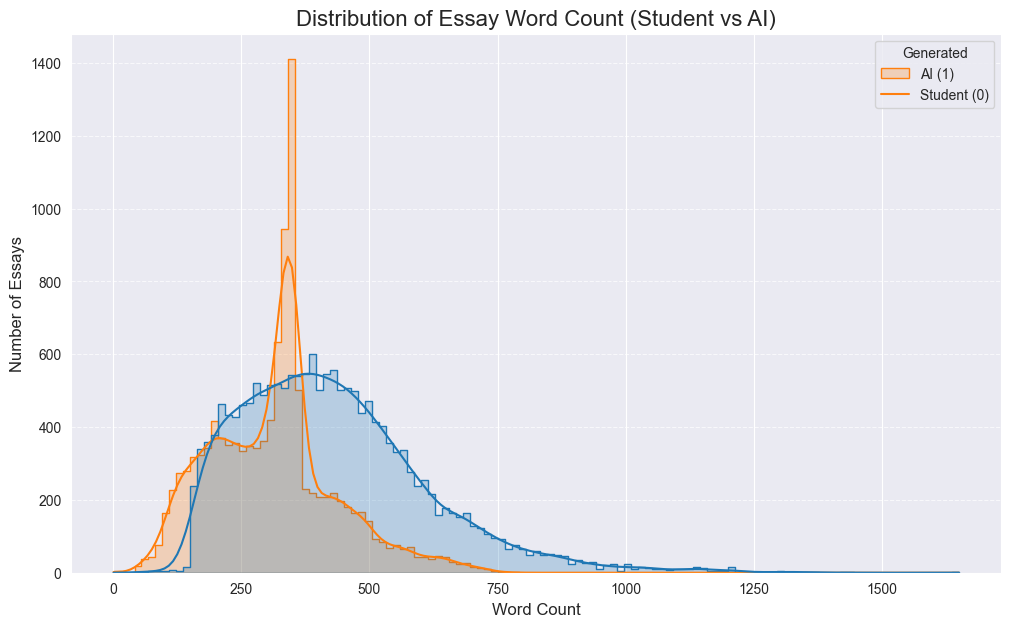

In [18]:
plt.figure(figsize=(12, 7))
sns.histplot(data=essay_df, x='word_count', hue='generated', kde=True, element='step')
plt.title('Distribution of Essay Word Count (Student vs AI)', fontsize=16)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Number of Essays', fontsize=12)
plt.legend(title='Generated', labels=['AI (1)', 'Student (0)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Preprocessing
### removal of duplicated values, encodingm scaling, text processing, datetime features, feature enineering, dimensionality reduction

In [19]:
## dropping duplicates
essay_df = essay_df.drop_duplicates(subset=['text'])

In [20]:
print(essay_df.duplicated().sum())

0


In [21]:
essay_df.head(10)

,text,generated,word_count
0,Car-free cities have become a subject of incre...,1,575
1,"Car Free Cities Car-free cities, a concept ga...",1,513
2,A Sustainable Urban Future Car-free cities ...,1,512
3,Pioneering Sustainable Urban Living In an e...,1,519
4,The Path to Sustainable Urban Living In an ...,1,511
5,A Paradigm Shift in Urban Living In an era ...,1,511
6,Revolutionizing Urban Living In an age defi...,1,507
7,Pioneering Sustainable Urban Living In an a...,1,492
8,Reimagining Urban Living In a rapidly urban...,1,475
9,A Vision of Urban Sustainability In our rap...,1,519


### 2. Ecoding
Here, a tool called TfidfVectorizer will be used. It convert text into numbers based on how those number are important in each essay.   
**args:  
1. max-features=1000: keep only the 1000 most important words.
2. stop-words='english': ignore common words in the English language like is, or, and, the, etc.

X = tfidf.fit_transform(essay-df['text']).  
This goess through each essay and creating a row of numbers called the feature matrix. This feature matrix is assigned to X. Each row is one essay and column is one word

New Balanced Value Counts:
generated
0    16122
1    16122
Name: count, dtype: int64


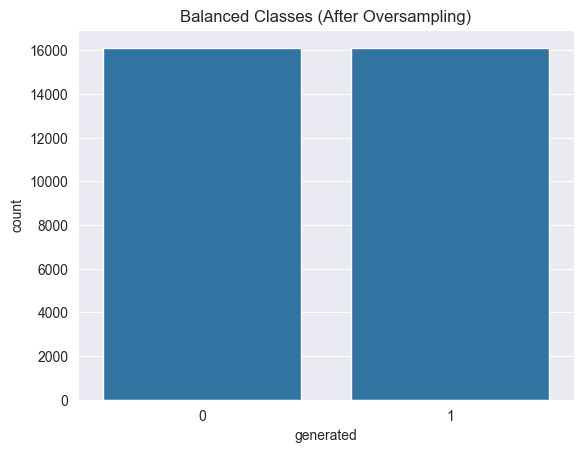

In [22]:
from sklearn.utils import resample

df_majority = essay_df[essay_df['generated'] == 0]
df_minority = essay_df[essay_df['generated'] == 1]

# Upsample the minority class to match the majority class
df_minority_oversampled = resample(df_minority,
                                 replace=True,     # Sample with replacement to make copies
                                 n_samples=len(df_majority), # Match the number of majority samples
                                 random_state=42)

# Combine the majority class with the upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_oversampled])

# Display the new class balance
print("New Balanced Value Counts:")
print(df_balanced['generated'].value_counts())

sns.countplot(x='generated', data=df_balanced)
plt.title('Balanced Classes (After Oversampling)')
plt.show()

In [23]:
# cleanning the data to remvoe irrelevant/non-meaningfull words
import re
def clean_text(text):
  text = text.lower()
  text = re.sub(r'[^a-z\s]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text

In [24]:
X = df_balanced['text']
y = df_balanced['generated']

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
)

In [26]:
X_train = X_train.to_frame()
X_test = X_test.to_frame()

In [27]:
X_train['clean_text'] = X_train['text'].apply(clean_text)
X_test['clean_text'] = X_test['text'].apply(clean_text)

converting text to features using TF-IDF

In [28]:
X_train

,text,clean_text
6288,Curiosity is a characteristic that is in every...,curiosity is a characteristic that is in every...
26841,The importance of a good night's sleep cannot ...,the importance of a good nights sleep cannot b...
20100,\nPositive thinking is an essential tool for a...,positive thinking is an essential tool for ach...
20671,\nMaking mistakes and failure are unavoidable ...,making mistakes and failure are unavoidable pr...
23652,People have different opinions on whether it i...,people have different opinions on whether it i...
...,...,...
24980,As the world continues to evolve and technolog...,as the world continues to evolve and technolog...
6844,In the passage The Challenge of Exploring Venu...,in the passage the challenge of exploring venu...
1611,Abolishing the Electoral College sounds like a...,abolishing the electoral college sounds like a...
18192,The first impression that is impossible to cha...,the first impression that is impossible to cha...


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    min_df=5,
    max_df=0.9
)

features_from_text_train = tfidf_vectorizer.fit_transform(X_train['clean_text']).toarray()
features_from_text_test = tfidf_vectorizer.transform(X_test['clean_text']).toarray()

print(f"Non-zero values:{np.count_nonzero(features_from_text_train)}")
print(f"Shape: {features_from_text_train.shape}")

feature_names = tfidf_vectorizer.get_feature_names_out()
print(feature_names[:20])

Non-zero values:1482414
Shape: (22570, 1000)
['ability' 'able' 'academic' 'access' 'accident' 'accidents' 'according'
 'achieve' 'achieving' 'act' 'action' 'actions' 'active' 'activities'
 'activity' 'actually' 'ad' 'addition' 'additional' 'additionally']


In [30]:
features_from_text_test

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03365787, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0830304 , 0.05592024, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.09848536, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(9674, 1000))

scaling and feature reduction

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(features_from_text_train)
X_test_scaled = scaler.transform(features_from_text_test)

In [32]:
from sklearn.decomposition import PCA
pca = PCA(
    n_components=1
)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

showing diff correlations bet data:

In [34]:
features_from_textdf = pd.DataFrame(
    features_from_text_train,
    columns=feature_names
)
print(features_from_textdf.head(3))

   ability  able  academic  access  accident  accidents  according  achieve  \
0      0.0   0.0       0.0     0.0  0.000000        0.0        0.0      0.0   
1      0.0   0.0       0.0     0.0  0.123658        0.0        0.0      0.0   
2      0.0   0.0       0.0     0.0  0.000000        0.0        0.0      0.0   

   achieving  act  ...  worthy  wouldnt  writing  wrong  year  years  yes  \
0   0.000000  0.0  ...     0.0      0.0      0.0    0.0   0.0    0.0  0.0   
1   0.123699  0.0  ...     0.0      0.0      0.0    0.0   0.0    0.0  0.0   
2   0.333625  0.0  ...     0.0      0.0      0.0    0.0   0.0    0.0  0.0   

   young  younger  youre  
0    0.0      0.0    0.0  
1    0.0      0.0    0.0  
2    0.0      0.0    0.0  

[3 rows x 1000 columns]


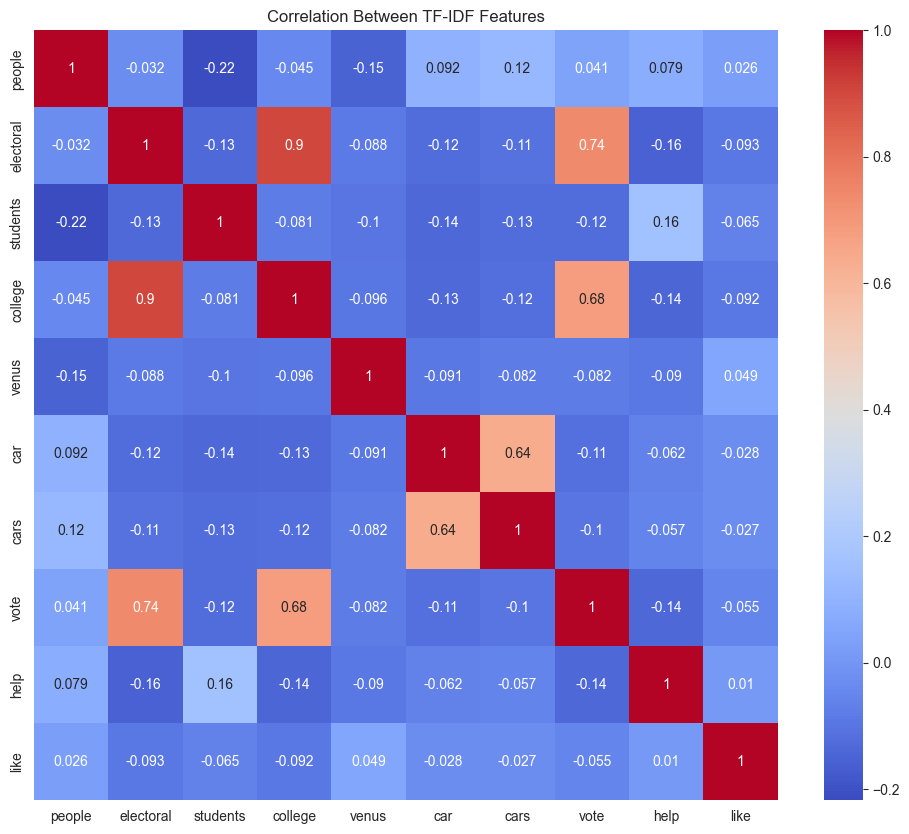

In [35]:
top10words = features_from_textdf.mean().sort_values(ascending=False).head(10).index.tolist()
correlation_matrix1 = features_from_textdf[top10words].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix1, cmap='coolwarm', annot=True)
plt.title("Correlation Between TF-IDF Features")
plt.show()

In [37]:
import plotly.express as px

top_20_words = features_from_textdf.mean().sort_values(ascending=False).head(20)

fig = px.bar(
    x=top_20_words.values,
    y=top_20_words.index,
    labels={'x': 'Avg TF-IDF Score', 'y': 'Word'},
    title='Top 20 Most Important Words (by Average TF-IDF Score)',
    color=top_20_words.values,
    color_continuous_scale='Viridis'
)

fig.show()

# Training the MLPClassifier Model

In [38]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (64, 32), (64,32,16)],
    'activation': ['relu', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

base_mlp = MLPClassifier(
    max_iter=200,
    early_stopping=True,
    random_state=42
)

grid_search = GridSearchCV(
    base_mlp, param_grid, cv=5,
    n_jobs=-1, verbose=1, scoring='accuracy'
)

grid_search.fit(X_train_pca, y_train)
best_model = grid_search.best_estimator_
print(f"best hyperparamters: {grid_search.best_params_}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
best hyperparamters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001}


In [39]:
final_model = MLPClassifier(activation='relu', alpha=0.0001, hidden_layer_sizes=[64,32], learning_rate_init=0.01, verbose=1).fit(X_train_pca, y_train)

Iteration 1, loss = 0.65610191
Iteration 2, loss = 0.63164792
Iteration 3, loss = 0.62778458
Iteration 4, loss = 0.62679990
Iteration 5, loss = 0.62568159
Iteration 6, loss = 0.62198284
Iteration 7, loss = 0.61978934
Iteration 8, loss = 0.62096662
Iteration 9, loss = 0.62054069
Iteration 10, loss = 0.61835469
Iteration 11, loss = 0.61715353
Iteration 12, loss = 0.61776348
Iteration 13, loss = 0.61790548
Iteration 14, loss = 0.61853391
Iteration 15, loss = 0.61547053
Iteration 16, loss = 0.61715055
Iteration 17, loss = 0.61494932
Iteration 18, loss = 0.61434666
Iteration 19, loss = 0.61318209
Iteration 20, loss = 0.61592987
Iteration 21, loss = 0.61325568
Iteration 22, loss = 0.61438019
Iteration 23, loss = 0.61514030
Iteration 24, loss = 0.61478297
Iteration 25, loss = 0.61481562
Iteration 26, loss = 0.61325448
Iteration 27, loss = 0.61277260
Iteration 28, loss = 0.61344387
Iteration 29, loss = 0.61428621
Iteration 30, loss = 0.61287170
Iteration 31, loss = 0.61286836
Iteration 32, los

In [40]:
print(f"accuracy score: {final_model.score(X_test_pca, y_test)}")

accuracy score: 0.5924126524705395



Test Accuracy: 0.6100
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61      4888
           1       0.60      0.62      0.61      4786

    accuracy                           0.61      9674
   macro avg       0.61      0.61      0.61      9674
weighted avg       0.61      0.61      0.61      9674

Cross-validation scores (5-fold): [0.59725299 0.61918476 0.61120957 0.61010191 0.60700044]
Mean CV Accuracy: 0.6089


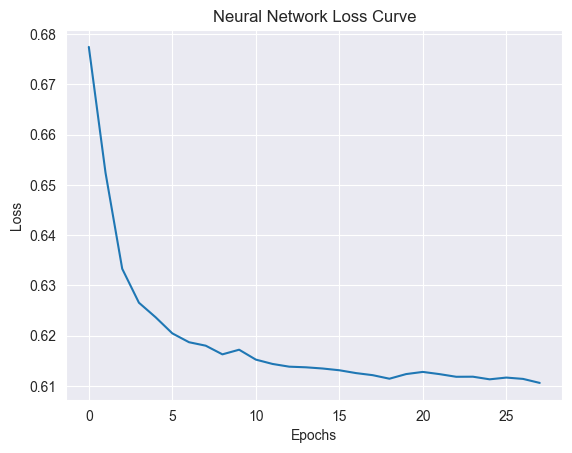

 Best model saved as 'best_nn_model.pkl'


In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report , ConfusionMatrixDisplay
import joblib
# Step 5: Evaluate on test set
y_predNN = best_model.predict(X_test_pca)
acc = accuracy_score(y_test, y_predNN)
print(f"\nTest Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_predNN))

# Step 6: Cross-validation on training set
cv_scores = cross_val_score(best_model, X_train_pca, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores (5-fold): {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

# Step 7: Plot loss curve
plt.plot(best_model.loss_curve_)
plt.title("Neural Network Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Step 8: Save the best model
joblib.dump(best_model, "best_nn_model.pkl")
print(" Best model saved as 'best_nn_model.pkl'")